In [8]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb

In [2]:
df = pd.read_csv('car-details (1).csv')
df.sample(5)

,name,company,model,edition,year,owner,fuel,seller_type,transmission,km_driven,mileage_mpg,engine_cc,max_power_bhp,torque_nm,seats,selling_price
5695,Maruti Swift Dzire ZDI,Maruti,Swift,Dzire ZDI,2013,Fourth & Above,Diesel,Individual,Manual,80000,55.00,1248.0,74.0,190.0,5.0,375000
2848,Maruti Ritz ZXi,Maruti,Ritz,ZXi,2013,Second,Petrol,Individual,Manual,60000,43.47,1197.0,85.8,114.0,5.0,415000
4199,Chevrolet Beat Diesel LS,Chevrolet,Beat,Diesel LS,2013,Second,Diesel,Individual,Manual,68000,59.78,936.0,57.6,150.0,5.0,175000
5384,BMW 6 Series GT 630d Luxury Line,BMW,6,Series GT 630d Luxury Line,2018,First,Diesel,Individual,Automatic,30000,40.16,2993.0,261.4,620.0,4.0,5830000
3264,Maruti Eeco 5 Seater AC BSIV,Maruti,Eeco,5 Seater AC BSIV,2019,First,Petrol,Individual,Manual,10000,36.12,1196.0,73.0,101.0,5.0,420000


In [7]:
df.nunique()

name             2058
company            32
model             207
edition          1916
year               29
owner               5
fuel                4
seller_type         3
transmission        2
km_driven         921
mileage_mpg       368
engine_cc         121
max_power_bhp     318
torque_nm         250
seats               9
selling_price     677
dtype: int64

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6926 entries, 0 to 6925
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   name           6926 non-null   object 
 1   company        6926 non-null   object 
 2   model          6926 non-null   object 
 3   edition        6926 non-null   object 
 4   year           6926 non-null   int64  
 5   owner          6926 non-null   object 
 6   fuel           6926 non-null   object 
 7   seller_type    6926 non-null   object 
 8   transmission   6926 non-null   object 
 9   km_driven      6926 non-null   int64  
 10  mileage_mpg    6718 non-null   float64
 11  engine_cc      6718 non-null   float64
 12  max_power_bhp  6717 non-null   float64
 13  torque_nm      6717 non-null   float64
 14  seats          6718 non-null   float64
 15  selling_price  6926 non-null   int64  
dtypes: float64(5), int64(3), object(8)
memory usage: 865.9+ KB


In [4]:
df.isna().sum()

name               0
company            0
model              0
edition            0
year               0
owner              0
fuel               0
seller_type        0
transmission       0
km_driven          0
mileage_mpg      208
engine_cc        208
max_power_bhp    209
torque_nm        209
seats            208
selling_price      0
dtype: int64

In [5]:
df.shape

(6926, 16)

Starting Hyperparameter Tuning for XGBoost...
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best Parameters: {'subsample': 0.7, 'n_estimators': 1000, 'max_depth': 5, 'learning_rate': 0.01, 'colsample_bytree': 0.7}

--- Full Evaluation Report ---
 MAE   : ₹54801.61
 MSE   : 6457614221.94
 RMSE  : 80359.28
 R²    : 0.8966
 MAPE  : 14.84%
 Accuracy (based on MAPE): 85.16%
 Explained Variance Score: 0.8967
 Median Absolute Error   : ₹37617.07


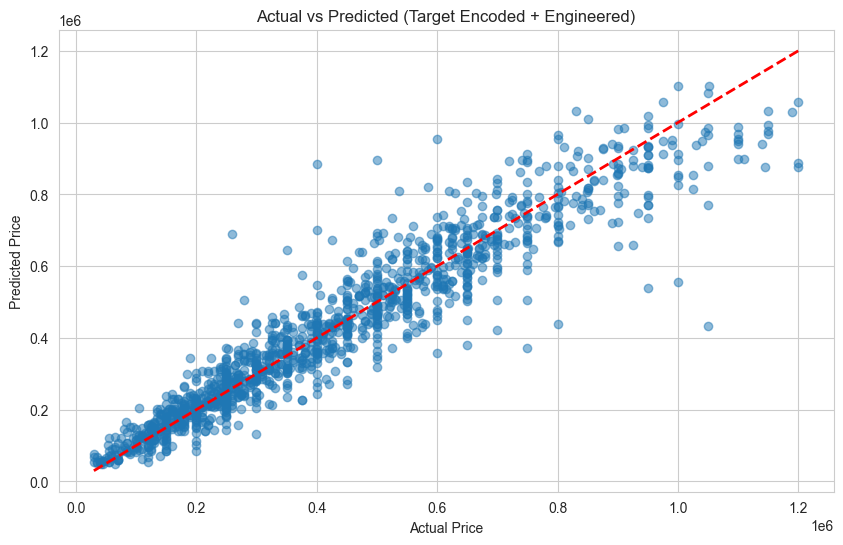

Saved plot to optimized_results.png


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import (
    mean_absolute_error, 
    r2_score, 
    mean_squared_error,
    explained_variance_score,
    median_absolute_error,
    mean_absolute_percentage_error
)


sns.set_style("whitegrid")

def load_and_clean_data(path):
    """Loads data, cleans it, and removes outliers (IQR on selling_price)."""
    df = pd.read_csv(path)

    # Attempt to coerce commonly messy numeric columns to numeric (strip non-numeric chars)
    def clean_numeric(col):
        if col in df.columns:
            df[col] = (df[col]
                       .astype(str)
                       .str.extract(r'([0-9]+(?:\.[0-9]+)?)')[0]  # grab first numeric part
                       .astype(float)
                      )

    for col in ['mileage_mpg', 'engine_cc', 'max_power_bhp', 'torque_nm', 'seats', 'km_driven', 'selling_price']:
        clean_numeric(col)

    # 1. Missing Values (Median Imputation) for selected numeric cols
    numeric_cols = ['mileage_mpg', 'engine_cc', 'max_power_bhp', 'torque_nm', 'seats', 'km_driven', 'selling_price']
    for col in numeric_cols:
        if col in df.columns:
            df[col] = df[col].fillna(df[col].median())

    # 2. Outlier Removal (IQR) on selling_price if present
    if 'selling_price' in df.columns:
        Q1 = df['selling_price'].quantile(0.25)
        Q3 = df['selling_price'].quantile(0.75)
        IQR = Q3 - Q1
        upper_bound = Q3 + 1.5 * IQR
        df = df[df['selling_price'] <= upper_bound].copy()

    return df.reset_index(drop=True)

def feature_engineering(df):
    """Creates new smart features and drops less useful cols."""
    current_year = pd.Timestamp.now().year

    

    # 2. Log Transform Target (Price) if selling_price exists
    if 'selling_price' in df.columns:
        df['price_log'] = np.log1p(df['selling_price'])

    # 3. Log Transform Skewed Feature (KM Driven)
    if 'km_driven' in df.columns:
        df['km_log'] = np.log1p(df['km_driven'].clip(lower=0))
        df = df.drop('km_driven', axis=1)

    # 4. Performance Ratio (Power per CC) with safety for zeros/missing
    if {'max_power_bhp', 'engine_cc'}.issubset(df.columns):
        df['engine_cc'] = df['engine_cc'].replace({0: np.nan})
        df['performance_ratio'] = df['max_power_bhp'] / df['engine_cc']
        # replace inf/nan with small number
        df['performance_ratio'] = df['performance_ratio'].replace([np.inf, -np.inf], np.nan).fillna(0)

    # Drop IDs/text columns that won't help the model directly
    df = df.drop(columns=['name', 'edition'], errors='ignore')

    return df

def target_encode(train_df, test_df, col, target_col):
    """
    Replaces a category with the average target value of that category.
    Computed on TRAIN only to avoid data leakage.
    Returns two Series: train_encoded, test_encoded (aligned by index of inputs)
    """
    means = train_df.groupby(col)[target_col].mean()
    train_encoded = train_df[col].map(means)
    test_encoded = test_df[col].map(means)

    global_mean = train_df[target_col].mean()
    train_encoded = train_encoded.fillna(global_mean)
    test_encoded = test_encoded.fillna(global_mean)

    return train_encoded, test_encoded

def preprocess_and_split(df):
    """
    Splits data FIRST, then applies encoding to prevent leakage.
    Returns X_train, X_test, y_train_log, y_test_log, y_test_actual
    """
    # Ensure target exists
    if 'price_log' not in df.columns or 'selling_price' not in df.columns:
        raise ValueError("DataFrame must contain 'price_log' and 'selling_price'.")

    X = df.drop(['selling_price', 'price_log'], axis=1)
    y_log = df['price_log']
    y_actual = df['selling_price']

    # Single consistent split for X and both label variants
    X_train, X_test, y_train_log, y_test_log, y_train_actual, y_test_actual = train_test_split(
        X, y_log, y_actual, test_size=0.2, random_state=42
    )

    # Target Encoding for high-cardinality columns if they exist
    for col in ['company', 'model']:
        if col in X_train.columns:
            train_temp = X_train.copy()
            train_temp['target'] = y_train_log.values  # attach target for grouping

            train_enc, test_enc = target_encode(train_temp, X_test, col, 'target')

            X_train[f'{col}_encoded'] = train_enc.values
            X_test[f'{col}_encoded'] = test_enc.values

            X_train = X_train.drop(col, axis=1)
            X_test = X_test.drop(col, axis=1)

    # Owner mapping (robust: use contains keyword and default)
    owner_mapping = {'Test Drive Car': 5, 'First': 4, 'Second': 3, 'Third': 2, 'Fourth & Above': 1}
    if 'owner' in X_train.columns:
        X_train['owner'] = (X_train['owner']
                            .astype(str)
                            .map(owner_mapping)
                            .fillna(2).astype(int))
        X_test['owner'] = (X_test['owner']
                           .astype(str)
                           .map(owner_mapping)
                           .fillna(2).astype(int))

    # One-Hot Encoding for categorical columns if present
    cat_cols = [c for c in ['fuel', 'seller_type', 'transmission'] if c in X_train.columns]
    if cat_cols:
        X_train = pd.get_dummies(X_train, columns=cat_cols, drop_first=True)
        X_test = pd.get_dummies(X_test, columns=cat_cols, drop_first=True)

    # Ensure train and test have same columns
    X_train, X_test = X_train.align(X_test, join='left', axis=1, fill_value=0)

    return X_train, X_test, y_train_log, y_test_log, y_test_actual

def tune_and_train(X_train, y_train):
    print("Starting Hyperparameter Tuning for XGBoost...")

    param_grid = {
        'n_estimators': [1000, 1500],
        'learning_rate': [0.01, 0.02],
        'max_depth': [5, 6],
        'subsample': [0.7, 0.8],
        'colsample_bytree': [0.7, 0.8]
    }

    xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42, n_jobs=-1)

    random_search = RandomizedSearchCV(estimator=xgb_model, param_distributions=param_grid,
                                       n_iter=10, cv=3, verbose=1, random_state=42, n_jobs=-1)

    random_search.fit(X_train, y_train)
    print(f"Best Parameters: {random_search.best_params_}")

    return random_search.best_estimator_

if __name__ == "__main__":
    # 1. Load
    df = load_and_clean_data('car-details (1).csv')   # adjust path if needed

    # 2. Engineer Features
    df_processed = feature_engineering(df)

    # 3. Split & Preprocess
    X_train, X_test, y_train_log, y_test_log, y_test_actual = preprocess_and_split(df_processed)

    # 4. Train (tuning)
    model = tune_and_train(X_train, y_train_log)

    # 5. Predict
    y_pred_log = model.predict(X_test)
    y_pred_actual = np.expm1(y_pred_log)

    # 6. Evaluate
    mae = mean_absolute_error(y_test_actual, y_pred_actual)
    mse = mean_squared_error(y_test_actual, y_pred_actual)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test_actual, y_pred_actual)
    mape = mean_absolute_percentage_error(y_test_actual, y_pred_actual)
    evs = explained_variance_score(y_test_actual, y_pred_actual)
    median_ae = median_absolute_error(y_test_actual, y_pred_actual)

    # Custom Accuracy Metric (Regression - based on MAPE)
    accuracy = (1 - mape) * 100

    print("\n--- Full Evaluation Report ---")
    print(f" MAE   : ₹{mae:.2f}")
    print(f" MSE   : {mse:.2f}")
    print(f" RMSE  : {rmse:.2f}")
    print(f" R²    : {r2:.4f}")
    print(f" MAPE  : {mape*100:.2f}%")
    print(f" Accuracy (based on MAPE): {accuracy:.2f}%")
    print(f" Explained Variance Score: {evs:.4f}")
    print(f" Median Absolute Error   : ₹{median_ae:.2f}")
    
    plt.figure(figsize=(10,6))
plt.scatter(y_test_actual, y_pred_actual, alpha=0.5)

# Identity line (perfect prediction)
plt.plot(
    [y_test_actual.min(), y_test_actual.max()],
    [y_test_actual.min(), y_test_actual.max()],
    'r--',
    lw=2
)

plt.title('Actual vs Predicted (Target Encoded + Engineered)')
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')

# Save
plt.savefig('optimized_results.png', bbox_inches='tight')

# Show the plot
plt.show()

print("Saved plot to optimized_results.png")
